<img src="./img/HWNI_logo.svg"/>

# Lab 07a - Bootstrapping

In [58]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# choose colors that work for most color-blind folks
sns.set_palette("colorblind")
sns.set(color_codes=True)

import util.lab06utils as utils 

# Generating Random Numbers

## Computers and Randomness

In [21]:
np.random.randn() #magic!

-0.3057988572881473

With a single command above, we are able to ask Python for a number whose exact value we are unable to predict, but whose probability distribution we can describe. Such a number is *random*. You can see this for yourself by running the cell above repeatedly. Different numbers come out each time!

But computers do not behave randomly -- randomness comes from factors that we do not control, and we have very intentionally designed computers in such a way that their macroscopic behavior is essentially unaffected by the factors that we do not control.

Instead, computers behave like functions: if you know their inputs, then you can figure out their outputs. 

When we perform bootstrapping or sampling, we need to generate "random" outputs -- a random shuffling of the labels of our data, for instance. Trouble is, if someone knows everything about the state of our computer, then they can perfectly reproduce the so-called "random" outputs. For statisticians, this turns out to be a problem that's more philosophical than practical -- if we don't know the exact state of our computer, then it *might as well be random* from our perspective. For cryptography, which relies on randomness, this distinction is critical.

This problem is usually solved by measuring something outside the memory of the computer -- the ones digit of the current time in milliseconds or the fifth decimal point of the temperature of the CPU. This number is then used to generate a very long sequence of numbers that have no obvious relationship between them. So long as we don't specifically control the measurement, the resulting output will appear random to us, and all of your statistical operations that rely on randomness will work.

The operation described above is called "seeding" the random number generator. It normally happens when we start using the random parts of numpy or Python, but we can ask for it to happen at any time by using the function `np.random.seed()` (with no arguments).

Run the cell below. Notice that the output is the same each time!

In [20]:
np.random.seed()
np.random.randn()

-0.2961667785519085

Now, let's ask Python for another random value using the same function.

In [ ]:
np.random.randn()

This number is different from the one generated by the cell with the seed in it, but it's the same if you run the cells one after the other (try it!).

We don't have to use a measurement as our seed. If we provide a (positive) number, Python will happily use that to seed the random number generator.

In [23]:
np.random.seed(5091991)

np.random.randn()

1.9649959891356643

The practical upshot of this is that, if you want, you can make all the code you run *reproducible*, so that someone running your code will get the same thing on their computer, even if it includes a "random" component. In this class, it will allow us to all get the exact same answers, provided we run the same pieces of code in the same order. If you make your results publicly available, this will allow others to directly replicate your results.

## Random Numbers in Python

The numpy library offers just about all of the random number functionality we need for this course. So we proceed after a quick **WARNING**: numpy is not "random enough" to be used in cryptography. If you make a billion-dollar website, don't use numpy for security-critical components of the website.

Numpy's random functions are nice because they are designed to produce lots of random numbers at once. We simply tell numpy the dimensions of the array of random numbers that we want, and it returns it to us.

In [33]:
randomVector = np.random.randn(10,1) # 10 by 1 random vector
print(randomVector)
print('')

randomMatrix = np.random.randn(3,3) # 3 by 3 random matrix
print(randomMatrix)
print('')

randomBlock = np.random.randn(2,2,2) # 2 by 2 by 2 random block
print(randomBlock)
print('')

[[-0.3153124 ]
 [-0.30006881]
 [-2.14808103]
 [ 0.41779905]
 [ 0.15104783]
 [ 0.83337099]
 [-0.70442748]
 [ 0.03564395]
 [ 1.0263234 ]
 [ 0.05419511]]

[[-0.4847771  -0.90428684 -0.79663492]
 [-0.31190474  0.00259495 -0.50312415]
 [ 0.55263583 -0.11834067  1.82185199]]

[[[-0.66152992 -0.76515855]
  [-1.39128051  0.65455533]]

 [[-0.94250993  0.03586979]
  [-0.34522996 -0.18273742]]]



We can confirm that the distribution of these numbers is, in fact, approximately normal by plotting it.

Below, generate at least 1000 samples from a random normal distribution and use seaborn's `distplot` to visualize it however you'd like. Hint: if you have a style that you like (I'm partial to `step`-styled histograms) you'll want to write a function that takes in some samples and produces a plot with that style.

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


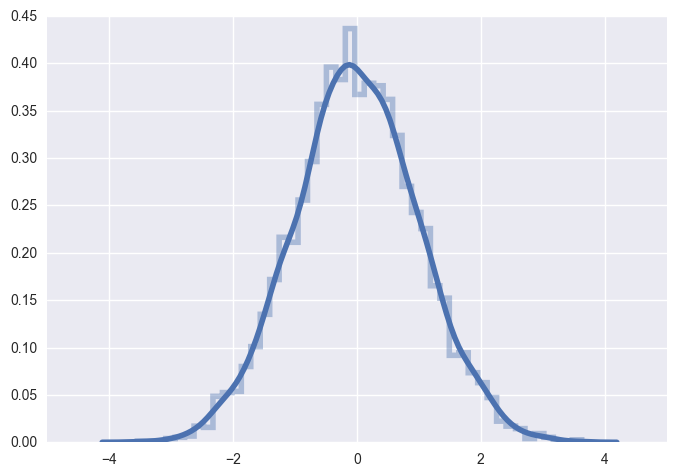

In [61]:
normalSample = np.random.randn(5000)

def plotDistribution(samples):
    hist_kws = {'histtype':'step',
            'linewidth':4,}
    kde_kws = {'linewidth':4}
    
    sns.distplot(samples,
             hist_kws=hist_kws,
            kde_kws=kde_kws);
    
plotDistribution(normalSample)

`numpy.random.randn` generates samples from the *standard normal distribution*, the normal (aka Gaussian) distribution with a mean of zero and a standard deviation of 1.

If we want normal random variables with a different mean and standard deviation, we simply add the mean and multiply by the standard deviation.

Below, generate another normally-distributed random vector with a different mean and standard deviation and plot the two on the same plot using `distplot`.

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


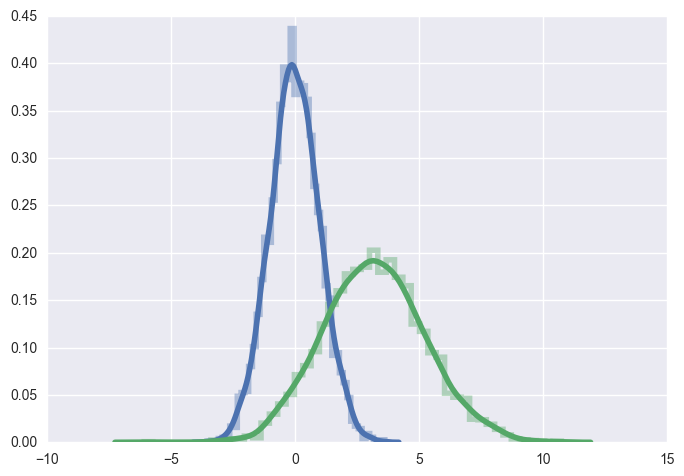

In [64]:
otherNormalVector = 2*np.random.randn(5000)+3.2

plotDistribution(normalSample)
plotDistribution(otherNormalVector)

Numpy offers many other distributions, some of which we've talked about in class.

Look up (either in numpy's online documentation or using the `function?` method) the random number generating functions below and produce a plot like the one you made above (i.e. comparing at least two large samples with different parameters) for each of them.

- `rand`
- `randint`
- `poisson`
- `exponential`

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


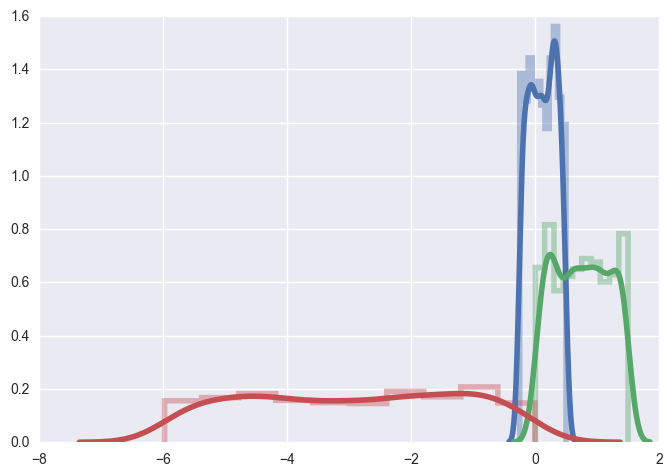

In [108]:
uniform1 = 0.75*np.random.rand(1000)-0.25
uniform2 = 1.5*np.random.rand(1000)
uniform3 = -6*np.random.rand(1000)

plotDistribution(uniform1)
plotDistribution(uniform2)
plotDistribution(uniform3)

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


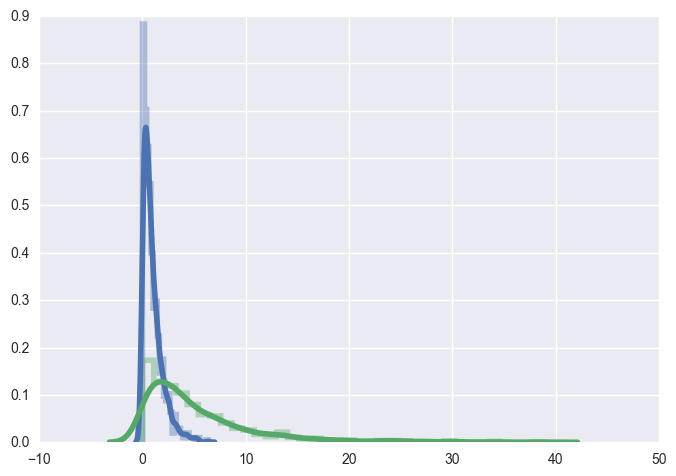

In [101]:
lowExponential = np.random.exponential(1,size=1000)
highExponential = np.random.exponential(5,size=1000)

plotDistribution(lowExponential)
plotDistribution(highExponential)

/Users/charlesfrye/anaconda/envs/neur299/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


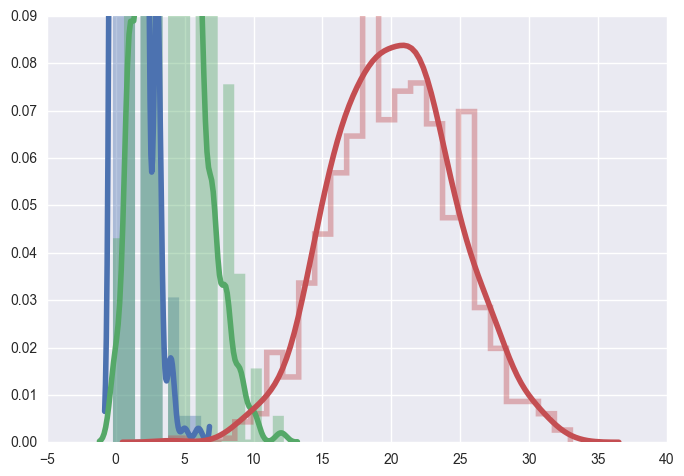

In [109]:
lowPoisson = np.random.poisson(1,size=1000)
middlePoisson = np.random.poisson(4,size=1000)
highPoisson = np.random.poisson(20,size=1000)

plotDistribution(lowPoisson)
plotDistribution(middlePoisson)
plotDistribution(highPoisson)